# GP

In [1]:
import sys
import os
import matplotlib.pyplot as plt

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
from elliptic_files.train_elliptic import samples_param
from elliptic_files.FEM_Solver import FEMSolver,Parametric_K
from elliptic_files.FEM_Solver import RootFinder

import time
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

/home/s2113174/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
class KernelFunction:
    def __init__(self, device):
        self.device = device

    def euclidean_distance(self, X, Y):
        return torch.cdist(X, Y)
    
    def d_euclidean_distance(self, X, Y):
        # X: (n, 1), Y: (m, 1)
        d = self.euclidean_distance(X, Y)  # shape (n, m)
        delta = X - Y.T                    # shape (n, m)

        # Avoid dividing by zero — we'll set those to 0
        zero_mask = (d == 0)
        dr_dx1 = torch.where(zero_mask, torch.zeros_like(d), delta / d)
        
        return dr_dx1, -dr_dx1
    
    def kernel(self,derivative_order=0):
        raise NotImplementedError("covariance must be implemented in a subclass.")
    
    def covariance(self, X,Y=None, derivative_order=0):
        Y = X if Y is None else Y.to(dtype=X.dtype)
        d = self.euclidean_distance(X, Y)
        return self.kernel(d, derivative_order=derivative_order)

class MaternKernel(KernelFunction):
    def __init__(self, sigma=1.0, l=1.0, device='cpu'):
        super().__init__(device)
        self._sigma = torch.tensor(sigma, dtype=torch.float64, device=device)
        self._l = torch.tensor(l, dtype=torch.float64, device=device)
        self.sqrt5 = torch.sqrt(torch.tensor(5.0, dtype=torch.float64, device=device))

    @property
    def sigma(self):
        return self._sigma

    @sigma.setter
    def sigma(self, new_sigma):
        if not isinstance(new_sigma, torch.Tensor):
            new_sigma = torch.tensor(new_sigma, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_sigma = new_sigma.to(dtype=torch.float64, device=self.device)
        self._sigma = new_sigma

    @property
    def l(self):
        return self._l

    @l.setter
    def l(self, new_l):
        if not isinstance(new_l, torch.Tensor):
            new_l = torch.tensor(new_l, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_l = new_l.to(dtype=torch.float64, device=self.device)
        self._l = new_l

    def matern52_kernel(self, r):
        term1 = 1 + self.sqrt5 * r / self.l + 5 * r**2 / (3 * self.l**2)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def d_matern52_kernel(self, r):
        term1 = -(5 / 3) * (r / self.l**2) - (self.sqrt5 * 5 * r**2) / (3 * self.l**3)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)

    def dd_matern52_kernel(self, r):
        term1 = -5 / (3 * self.l**2) - (5 / 3) * (r * self.sqrt5 / self.l**3) + (25 * r**2) / (3 * self.l**4)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def ddd_matern52_kernel(self, r):
        #term1 = 25 / (3 * self.l**4) + (75 * r)/ (3 * self.l**4) -  (25 * self.sqrt5 * r**2)/ (3 * self.l**5)
        term1 = (75 * r)/ (3 * self.l**4) -  (25 * self.sqrt5 * r**2)/ (3 * self.l**5)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)
    
    def dddd_matern52_kernel(self, r):
        #term1 = 50 / (3 * self.l**4) - (25 * self.sqrt5)/ (3 * self.l**5) + (r**2 * 5**3) / (3*self.l**6)
        term1 = 75 / (3 * self.l**4) - (125 * self.sqrt5*r)/ (3 * self.l**5) + (r**2 * 125) / (3*self.l**6)
        return self.sigma**2 * term1 * torch.exp(-self.sqrt5 * r / self.l)

    def kernel(self, r, derivative_order=0):
        if derivative_order == 0:
            return self.matern52_kernel(r)
        elif derivative_order == 1:
            return self.d_matern52_kernel(r)
        elif derivative_order == 2:
            return self.dd_matern52_kernel(r)
        elif derivative_order == 3:
            return self.ddd_matern52_kernel(r)
        elif derivative_order == 4:
            return self.dddd_matern52_kernel(r)
        else:
            raise ValueError(f"Unsupported derivative order: {derivative_order}")

class SquaredExponential(KernelFunction):
    def __init__(self, sigma=1.0, l=1.0, device='cpu'):
        super().__init__(device)
        self._sigma = torch.tensor(sigma, dtype=torch.float64, device=device)
        self._l = torch.tensor(l, dtype=torch.float64, device=device)

    @property
    def sigma(self):
        return self._sigma

    @sigma.setter
    def sigma(self, new_sigma):
        if not isinstance(new_sigma, torch.Tensor):
            new_sigma = torch.tensor(new_sigma, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_sigma = new_sigma.to(dtype=torch.float64, device=self.device)
        self._sigma = new_sigma

    @property
    def l(self):
        return self._l

    @l.setter
    def l(self, new_l):
        if not isinstance(new_l, torch.Tensor):
            new_l = torch.tensor(new_l, dtype=torch.float64, device=self.device, requires_grad=False)
        else:
            new_l = new_l.to(dtype=torch.float64, device=self.device)
        self._l = new_l

    def squared_exponential_cov(self, r):
        return (self.sigma**2) * torch.exp(-0.5 * (r / self.l) ** 2)

    def d_squared_exponential_cov(self, r):
        return -((self.sigma / self.l) ** 2) * r * torch.exp(-0.5 * (r / self.l) ** 2)

    def dd_squared_exponential_cov(self, r):
            return (-1/self.l**2 + r**2/self.l**4 )*self.squared_exponential_cov(r)
    
    def ddd_squared_exponential_cov(self, r):
            return (3*r / self.l**4 - r**3 / self.l**6)*self.squared_exponential_cov(r)
    
    def dddd_squared_exponential_cov(self, r):
            return (3 / self.l**4 - 6*r**2 /self.l**6 + r**4 / self.l**8)*self.squared_exponential_cov(r)

    def kernel(self, r, derivative_order=0):
        if derivative_order == 0:
            return self.squared_exponential_cov(r)
        elif derivative_order == 1:
            return self.d_squared_exponential_cov(r)
        elif derivative_order == 2:
            return self.dd_squared_exponential_cov(r)
        elif derivative_order == 3:
            return self.ddd_squared_exponential_cov(r)
        elif derivative_order == 4:
            return self.dddd_squared_exponential_cov(r)
        else:
            raise ValueError(f"Unsupported derivative order: {derivative_order}")



In [3]:
class PIGP:
    def __init__(self, data_training, reg_matrix=1e-10,sigma_l_parameters=(1, 1), sigma_l_spatial=(1, 1),device = "cpu"):

        self.device = device
        # Training data
        self.parameters_data = torch.tensor(data_training["parameters_data"], dtype=torch.float64,device=self.device)
        self.solutions_data = torch.tensor(data_training["solutions_data"], dtype=torch.float64,device=self.device)
        self.x_sol_data = torch.tensor(data_training["x_solutions_data"], dtype=torch.float64,device=self.device)

        self.x_bc = torch.tensor(data_training["x_bc"], dtype=torch.float64,device=self.device)
        self.y_bc = torch.tensor(data_training["y_bc"], dtype=torch.float64,device=self.device)

        self.source_func_x = torch.tensor(data_training["source_func_x"], dtype=torch.float64,device=self.device)
        self.source_func_f_x = torch.tensor(data_training["source_func_f_x"], dtype=torch.float64,device=self.device)

        self.n_parameter_obs = self.parameters_data.shape[0]
        self.parameter_dim = self.parameters_data.shape[-1]

        self.kernel_parameter = SquaredExponential(*sigma_l_parameters,device=self.device)
        self.kernel_spatial = MaternKernel(*sigma_l_spatial,device=self.device)
        
        self.reg_matrix = reg_matrix

    def train_gp(self):
          self.g_trained = self.g_training()
          self.kuf = self.kernel_uf(self.parameters_data,self.x_sol_data)
          self.cov_matrix, self.kuu, self.kug = self.informed_kernel(self.parameters_data, self.parameters_data)
          self.invk_g = self.kernel_inverse(self.cov_matrix, self.g_trained)

    def exp_kl_eval(self, theta, x):
        """Define the likelihood function for the coarse model. Must be overridden."""
        raise NotImplementedError("log_likelihood must be implemented in a subclass.")
     
    def grad_kl_eval(self, theta, x):
        """Define the likelihood function for the coarse model. Must be overridden."""
        raise NotImplementedError("log_likelihood must be implemented in a subclass.")
    
    def kernel_uf(self, theta, x):
        exp_kl = self.exp_kl_eval(theta, self.source_func_x.T)
        grad_kl = self.grad_kl_eval(theta, self.source_func_x.T)

        _,dr_dx = self.kernel_spatial.d_euclidean_distance(x, self.source_func_x)
        dk_dr = self.kernel_spatial.covariance(x,self.source_func_x, derivative_order=1)
        ddk_ddr = self.kernel_spatial.covariance(x,self.source_func_x, derivative_order=2)
    
        # Reshape for broadcasting
        exp_kl = exp_kl.unsqueeze(1)           # [B, 1, S]
        grad_kl = grad_kl.unsqueeze(1)         # [B, 1, S]
        dr_dx   = dr_dx.unsqueeze(0)           # [1, N, S]
        dk_dr   = dk_dr.unsqueeze(0)           # [1, N, S]
        ddk_ddr = ddk_ddr.unsqueeze(0)         # [1, N, S]

        # Compute [B, N, S] via broadcasting
        pi_gp = grad_kl * dk_dr * dr_dx + ddk_ddr 
        return -pi_gp * exp_kl  # [B, N, S]
    
    def kernel_ff(self, theta1, theta2):

        exp_kl1 = self.exp_kl_eval(theta1, self.source_func_x.T).view(-1, 1)
        grad_kl1 = self.grad_kl_eval(theta1, self.source_func_x.T).view(-1, 1)
        exp_kl2 = self.exp_kl_eval(theta2, self.source_func_x.T).view(-1, 1)
        grad_kl2 = self.grad_kl_eval(theta2, self.source_func_x.T).view(-1, 1)

        dr_dx1,_ = self.kernel_spatial.d_euclidean_distance(self.source_func_x, self.source_func_x)
        ddk = self.kernel_spatial.covariance(self.source_func_x,self.source_func_x, derivative_order=2)
        dddk = self.kernel_spatial.covariance(self.source_func_x,self.source_func_x, derivative_order=3)
        ddddk = self.kernel_spatial.covariance(self.source_func_x,self.source_func_x, derivative_order=4)

        llk = (-grad_kl1*grad_kl2.T*ddk + (grad_kl1- grad_kl2.T)*dddk*dr_dx1 + ddddk)*exp_kl1*exp_kl2.T
        return llk 
    
    def block_matrix_builder_ff(self, th1, th2):
        nth1, nth2 = th1.shape[0], th2.shape[0]
        blocks = []

        for i in range(nth1):
            row_blocks = []
            for j in range(nth2):
                theta1 = th1[i, :]
                theta2 = th2[j, :]
                cov_scalar = self.kernel_parameter.covariance(theta1.view(1, -1), theta2.view(1, -1))
                pde_matrix = self.kernel_ff(theta1.unsqueeze(0), theta2.unsqueeze(0))
                row_blocks.append(cov_scalar * pde_matrix)
            blocks.append(torch.cat(row_blocks, dim=1))
        return torch.cat(blocks, dim=0)
    
    def block_matrix_builder_uf(self, th1, th2, x = None):
        cov_matrix = self.kernel_parameter.covariance(th1, th2)  # [nth1, nth2]

        if x is None:
            pde_matrices = self.kuf # [nth2, N, S]
            x = self.x_sol_data
        else:
            pde_matrices = self.kernel_uf(th2, x)

        # Broadcast cov scalars over PDEs
        # [nth1, nth2, 1, 1] * [1, nth2, N, S] → [nth1, nth2, N, S]
        blocks = cov_matrix.unsqueeze(-1).unsqueeze(-1) * pde_matrices.unsqueeze(0)

        # Stack the final block matrix
        result = torch.cat(
            [blocks[i].transpose(0, 1).reshape(x.shape[0], -1) for i in range(th1.shape[0])],
            dim=0
        )  # shape: [nth1 * N, nth2 * S]
        return result
    
    def informed_kernel(self, theta1, theta2):
        kernel_param = self.kernel_parameter.covariance(theta1, theta2)

        kuu = self.kernel_spatial.covariance(self.x_sol_data, self.x_sol_data)
        Kuu = torch.kron(kernel_param, kuu)

        kug = self.kernel_spatial.covariance(self.x_sol_data, self.x_bc)
        Kug = torch.kron(kernel_param, kug)

        Kuf = self.block_matrix_builder_uf(theta1, theta2)

        kgg = self.kernel_spatial.covariance(self.x_bc, self.x_bc)
        Kgg = torch.kron(kernel_param, kgg)

        Kgf = self.block_matrix_builder_uf(theta1, theta2, self.x_bc)
        Kff = self.block_matrix_builder_ff(theta1, theta2)

        top = torch.cat([Kuu, Kug, Kuf], dim=1)
        middle = torch.cat([Kug.T, Kgg, Kgf], dim=1)
        bottom = torch.cat([Kuf.T, Kgf.T, Kff], dim=1)
        cov = torch.cat([top, middle, bottom], dim=0)

        return cov + self.reg_matrix * torch.eye(cov.shape[0], dtype=torch.float64, device=self.device),kuu,kug
    
    def g_training(self):
        y_bc_n = self.y_bc.repeat((self.n_parameter_obs,1))
        f_source_n = self.source_func_f_x.repeat((self.n_parameter_obs,1))
        return torch.cat([self.solutions_data.view(-1, 1), y_bc_n, f_source_n])

    def kernel_inverse(self, cov_matrix, Y):
        return torch.linalg.solve(cov_matrix, Y)

    def marginal_likelihood(self, sigma_spatial, l_spatial, sigma_param, l_param):
        # Update kernel parameters
        self.kernel_spatial.sigma, self.kernel_spatial.l = sigma_spatial, l_spatial
        self.kernel_parameter.sigma, self.kernel_parameter.l = sigma_param, l_param

        # Recompute the covariance matrix
        self.kuf = self.kernel_uf(self.parameters_data,self.x_sol_data)
        self.cov_matrix, _, _ = self.informed_kernel(self.parameters_data, self.parameters_data)
        
        # Compute Cholesky
        L = torch.linalg.cholesky(self.cov_matrix)

        # Solve K^{-1}y
        y = self.g_trained
        alpha =self.kernel_inverse(self.cov_matrix,y)

        # Log determinant
        logdet_K = 2.0 * torch.sum(torch.log(torch.diag(L)))
        return -0.5 * ((y.T @ alpha).squeeze() + logdet_K + y.shape[0] * np.log(2 * np.pi))
    

    def optimize_mll(self, lr=1e-2):
    # Start from log of current parameters
        log_sigma_spatial = self.kernel_spatial.sigma.detach().log().clone().requires_grad_()
        log_l_spatial = self.kernel_spatial.l.detach().log().clone().requires_grad_()
        log_sigma_param = self.kernel_parameter.sigma.detach().log().clone().requires_grad_()
        log_l_param = self.kernel_parameter.l.detach().log().clone().requires_grad_()

        params = [log_sigma_spatial, log_l_spatial, log_sigma_param, log_l_param]
        optimizer = torch.optim.LBFGS(params, lr=lr, max_iter=100, line_search_fn='strong_wolfe')

        def closure():
            optimizer.zero_grad()

            # Exponentiate to ensure positivity
            sigma_spatial = log_sigma_spatial.exp()
            l_spatial = log_l_spatial.exp()
            sigma_param = log_sigma_param.exp()
            l_param = log_l_param.exp()

            nll = -self.marginal_likelihood(sigma_spatial, l_spatial, sigma_param, l_param)
            nll.backward()
            return nll

        optimizer.step(closure)

        # Update final values after optimization
        self.kernel_spatial.sigma = log_sigma_spatial.exp().detach()
        self.kernel_spatial.l = log_l_spatial.exp().detach()
        self.kernel_parameter.sigma = log_sigma_param.exp().detach()
        self.kernel_parameter.l = log_l_param.exp().detach()

        print("Optimized parameters:")
        print(f"(sigma_spatial,l_spatial) = ({self.kernel_spatial.sigma},{self.kernel_spatial.l})")
        print(f"(sigma_parameter,l_parameter) = ({self.kernel_parameter.sigma},{self.kernel_parameter.l})")
        self.train_gp()

    def marginal_val(self, theta_test, x_test=None):
        kernel_param = self.kernel_parameter.covariance(theta_test, self.parameters_data)

        if x_test is None:
            x_test = self.x_sol_data
            Kuf = self.block_matrix_builder_uf(theta_test, self.parameters_data)
            kuu = self.kuu
            kug = self.kug
        else: 
            Kuf = self.block_matrix_builder_uf(theta_test, self.parameters_data,x_test)

            kuu = self.kernel_spatial.covariance(x_test, self.x_sol_data)
            
            kug = self.kernel_spatial.covariance(x_test, self.x_bc)

        Kuu = torch.kron(kernel_param, kuu)

        Kug = torch.kron(kernel_param, kug)
        
        return torch.cat([Kuu, Kug, Kuf], dim=1)

    def prediction(self, theta_test, x_test=None, var=True):
        matrix_test = self.marginal_val(theta_test, x_test)
        marginal_mean = matrix_test @ self.invk_g

        if var:
            kernel_spatial = self.kuu if x_test is None else  self.kernel_spatial.covariance(x_test, x_test)
            kernel_param = self.kernel_parameter.covariance(theta_test, theta_test)
            kinv_y = self.kernel_inverse(self.cov_matrix, matrix_test.T)
            cov = torch.kron(kernel_param, kernel_spatial) - matrix_test @ kinv_y
            return marginal_mean, cov
        return marginal_mean

In [4]:
class Elliptic1DPIGP(PIGP):
    def __init__(self, data_training, reg_matrix=1e-5, lam=1/4,sigma_l_parameters=(1, 1), sigma_l_spatial=(1, 1),device = "cpu"):
        super(Elliptic1DPIGP, self).__init__(data_training = data_training , reg_matrix=reg_matrix,
                             sigma_l_parameters=sigma_l_parameters, sigma_l_spatial=sigma_l_spatial,device=device)
            
        # Roots for KL
        self.finder = RootFinder(lam, self.parameter_dim)
        self.roots = torch.tensor(self.finder.find_roots(), dtype=torch.float64,device=self.device)
        self.kuf = self.kernel_uf(self.parameters_data,self.x_sol_data)


    @property
    def A(self):
        r = self.roots
        return torch.sqrt(1 / ((1/8)*(5 + (r / 2)**2) + 
                            (torch.sin(2*r) / (4*r)) * ((r / 4)**2 - 1) - (torch.cos(2*r)/8)))
    @property
    def an(self):
        return torch.sqrt(8 / (self.roots**2 + 16))
    
    
    def exp_kl_eval(self, theta, x):
        basis = self.A[:, None] * self.an[:, None] * (torch.sin(self.roots[:, None] * x) +
                    (self.roots[:, None] / 4) * torch.cos(self.roots[:, None] * x))
        result = theta @ basis
        return torch.exp(result).to(self.device)

    def grad_kl_eval(self, theta, x):
        basis = self.A[:, None] * self.an[:, None] * self.roots[:, None] * (
            torch.cos(self.roots[:, None] * x) - (self.roots[:, None] / 4) * torch.sin(self.roots[:, None] * x))
        res = theta @ basis
        return res.to(self.device)

In [5]:

obs, nthetas = 6, 100
nparams = 4
thetas  = samples_param(nthetas,nparam=nparams)
#print(thetas)


fem_solver = FEMSolver(np.zeros(nparams),M=nparams,vert=50)
obs_points = np.linspace(0.2,0.8,obs).reshape(-1,1)
training_data = np.zeros((nthetas,obs ))

for i,theta in enumerate(thetas):
    fem_solver.theta = theta
    start = time.time()

    fem_solver.solve()
    end = time.time()
    #print(f"Time taken: {end - start} seconds")

    training_data[i,:] = fem_solver.eval_at_points(obs_points).reshape(1, -1)


xf = torch.linspace(1e-10,0.999,10).view(-1, 1)
yf = (4*xf).reshape(-1,1) # training data
x_bc = torch.tensor([0,1]).reshape(-1,1)
y_bc = torch.tensor([0,2]).reshape(-1,1)

data_training = {"parameters_data": torch.tensor(thetas).to(device),
                 "solutions_data": torch.tensor(training_data).to(device),
                 "x_solutions_data":obs_points,
                 "x_bc": x_bc.to(device),
                 "y_bc": y_bc.to(device),
                 "source_func_x": xf.to(device),
                 "source_func_f_x":yf.to(device)
                   }

#data_training = {key: torch.tensor(np.array(value))  for key,value in data_training.items() }

elliptic_gp = Elliptic1DPIGP(data_training,sigma_l_parameters=(1, 1), sigma_l_spatial=(1, 1),device=device)
elliptic_gp.train_gp()
elliptic_gp.optimize_mll()

Optimized parameters:
(sigma_spatial,l_spatial) = (0.8930022999225548,0.2980376740451004)
(sigma_parameter,l_parameter) = (0.8930022987142382,4.930044034847441)


In [14]:
model_specific = f"_spatial{6}_nsol{100}_kl{4}"

torch.save(elliptic_gp, f"./models/elliptic_pigp_{model_specific}.pt")


In [6]:
obs, nthetas = 6, 8
thetas  = samples_param(nthetas,nparam=nparams, seed=0)
fem_solver = FEMSolver(np.zeros(nparams),M=nparams,vert=50)
obs_points = np.linspace(0.2,0.8,obs).reshape(-1,1)
training_data = np.zeros((nthetas,obs ))

for i,theta in enumerate(thetas):
    fem_solver.theta = theta
    fem_solver.solve()
    training_data[i,:] = fem_solver.eval_at_points(obs_points).reshape(1, -1)

In [7]:
theta_th = torch.tensor([0.8403, 0.1736, 0.5060, 0.0105]).reshape(1,-1)
mean, var = elliptic_gp.prediction(theta_th)
mean

tensor([[0.4035],
        [0.6493],
        [0.9259],
        [1.2152],
        [1.4798],
        [1.7001]], dtype=torch.float64)

In [8]:
matrix_test = elliptic_gp.marginal_val(theta_th, None)
marginal_mean = matrix_test @ elliptic_gp.invk_g

kernel_spatial = elliptic_gp.kuu
kernel_param = elliptic_gp.kernel_parameter.covariance(theta_th, theta_th)
kinv_y = elliptic_gp.kernel_inverse(elliptic_gp.cov_matrix, matrix_test.T)
cov = torch.kron(kernel_param, kernel_spatial) - matrix_test @ kinv_y
print(torch.kron(kernel_param, kernel_spatial))
print(matrix_test @ kinv_y)
print(cov)

        # if var:
        #     kernel_spatial = self.kuu if x_test is None else  self.kernel_spatial.covariance(x_test, x_test)
        #     kernel_param = self.kernel_parameter.covariance(theta_test, theta_test)
        #     kinv_y = self.kernel_inverse(self.cov_matrix, matrix_test.T)
        #     cov = torch.kron(kernel_param, kernel_spatial) - matrix_test @ kinv_y
        #     return marginal_mean, cov
        # return marginal_mean

tensor([[0.6359, 0.5610, 0.4077, 0.2618, 0.1549, 0.0864],
        [0.5610, 0.6359, 0.5610, 0.4077, 0.2618, 0.1549],
        [0.4077, 0.5610, 0.6359, 0.5610, 0.4077, 0.2618],
        [0.2618, 0.4077, 0.5610, 0.6359, 0.5610, 0.4077],
        [0.1549, 0.2618, 0.4077, 0.5610, 0.6359, 0.5610],
        [0.0864, 0.1549, 0.2618, 0.4077, 0.5610, 0.6359]], dtype=torch.float64)
tensor([[0.6359, 0.5610, 0.4077, 0.2618, 0.1549, 0.0864],
        [0.5610, 0.6359, 0.5610, 0.4077, 0.2618, 0.1549],
        [0.4077, 0.5610, 0.6359, 0.5610, 0.4077, 0.2618],
        [0.2618, 0.4077, 0.5610, 0.6359, 0.5610, 0.4077],
        [0.1549, 0.2618, 0.4077, 0.5610, 0.6359, 0.5610],
        [0.0864, 0.1549, 0.2618, 0.4077, 0.5610, 0.6359]], dtype=torch.float64)
tensor([[ 9.8311e-07,  1.4109e-07,  2.0211e-07,  3.3495e-07,  3.3137e-07,
          2.5663e-07],
        [ 1.4109e-07,  8.2621e-07,  6.3949e-08,  1.6751e-07,  3.2479e-07,
          3.3352e-07],
        [ 2.0211e-07,  6.3949e-08,  7.4821e-07,  2.7222e-08,  1.49

In [9]:
gp = torch.load(f"./models/elliptic_pigp__spatial6_nsol{100}_kl{4}.pt")
mean, var = gp.prediction(theta_th)

matrix_test = gp.marginal_val(theta_th, None)
marginal_mean = matrix_test @ gp.invk_g

kernel_spatial = gp.kuu
kernel_param = gp.kernel_parameter.covariance(theta_th, theta_th)
kinv_y = gp.kernel_inverse(gp.cov_matrix, matrix_test.T)
cov = torch.kron(kernel_param, kernel_spatial) - matrix_test @ kinv_y
print(torch.kron(kernel_param, kernel_spatial))
print(matrix_test @ kinv_y)
print(cov)

tensor([[0.5719, 0.5148, 0.3920, 0.2671, 0.1688, 0.1010],
        [0.5148, 0.5719, 0.5148, 0.3920, 0.2671, 0.1688],
        [0.3920, 0.5148, 0.5719, 0.5148, 0.3920, 0.2671],
        [0.2671, 0.3920, 0.5148, 0.5719, 0.5148, 0.3920],
        [0.1688, 0.2671, 0.3920, 0.5148, 0.5719, 0.5148],
        [0.1010, 0.1688, 0.2671, 0.3920, 0.5148, 0.5719]], dtype=torch.float64)
tensor([[0.5719, 0.5148, 0.3920, 0.2671, 0.1688, 0.1010],
        [0.5148, 0.5719, 0.5148, 0.3920, 0.2671, 0.1688],
        [0.3920, 0.5148, 0.5719, 0.5148, 0.3920, 0.2671],
        [0.2671, 0.3920, 0.5148, 0.5719, 0.5148, 0.3920],
        [0.1688, 0.2671, 0.3920, 0.5148, 0.5719, 0.5148],
        [0.1010, 0.1688, 0.2671, 0.3920, 0.5148, 0.5719]], dtype=torch.float64)
tensor([[-1.1659e-06, -8.9443e-07, -1.2940e-07,  4.4277e-07,  6.5204e-07,
          6.3447e-07],
        [-8.9443e-07, -1.2190e-06, -9.7822e-07, -2.4173e-07,  3.3821e-07,
          6.3498e-07],
        [-1.2940e-07, -9.7822e-07, -1.3287e-06, -1.1086e-06, -3.81

In [10]:
mean

tensor([[0.4022],
        [0.6474],
        [0.9236],
        [1.2143],
        [1.4805],
        [1.7021]], dtype=torch.float64)

Time eval: 0.0518796443939209 seconds
Time eval: 0.05836844444274902 seconds
Time eval: 0.05489921569824219 seconds
Time eval: 0.0628204345703125 seconds
Time eval: 0.07354497909545898 seconds
Time eval: 0.04776453971862793 seconds
Time eval: 0.04371762275695801 seconds
Time eval: 0.04094219207763672 seconds


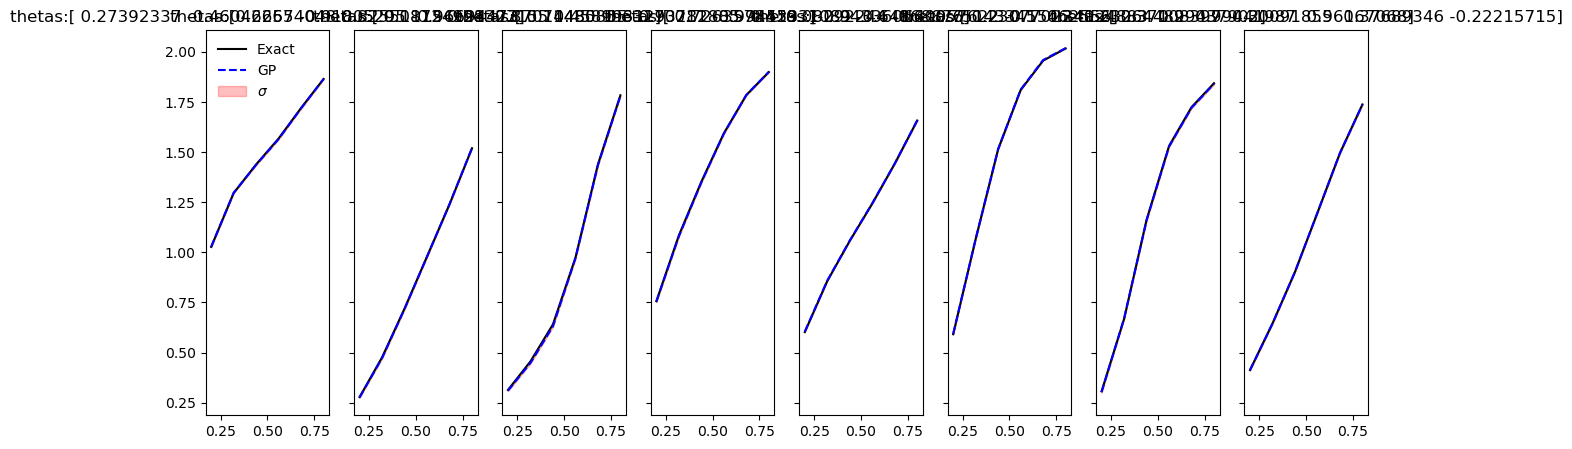

In [11]:
fig, axs = plt.subplots(1,nthetas, figsize=(15, 5), sharey="row", sharex="row")

for i in range(nthetas):
    start = time.time()
    mean, var = elliptic_gp.prediction(torch.tensor(thetas[i,:],device=device).reshape(1,-1))
    end = time.time()
    print(f"Time eval: {end - start} seconds")

    #std = jnp.sqrt(jnp.diag(var))
    std = torch.sqrt(torch.diag(var)).cpu().numpy()

    axs[i].plot(obs_points,training_data[i,:], color = "black", label = "Exact")
    axs[i].plot(obs_points,mean.cpu().numpy(),linestyle="--",color = "blue", label = "GP")
    axs[i].fill_between(obs_points.flatten(),mean.cpu().numpy().flatten() + std,mean.cpu().numpy().flatten() - std, color = "r", alpha= 0.25, label =r"$\sigma$")
    axs[i].set_title(f"thetas:{thetas[i,:]}")
axs[0].legend(frameon=False)

In [21]:
import numpy as np
import torch
from torch.distributions import MultivariateNormal

from Base.mcmc import MetropolisHastings,MCMCDA
from Base.lla import dgala

from elliptic_files.FEM_Solver import FEMSolver
from elliptic_files.elliptic import Elliptic

class EllipticMCMC(MetropolisHastings):
    def __init__(self, surrogate, observation_locations, observations_values, nparameters=2, 
                 observation_noise=0.5, nsamples=1000000, burnin=None, proposal_type="random_walk",
                 step_size=0.1,uniform_limit=1,my_reg = 1e-3, device="cpu", gp_marginal = True):
        
        super(EllipticMCMC, self).__init__(observation_locations =observation_locations, observations_values=observations_values, nparameters=nparameters, 
                 observation_noise=observation_noise, nsamples=nsamples, burnin=burnin, proposal_type=proposal_type, step_size=step_size,
                 uniform_limit=uniform_limit,my_reg=my_reg,device=device)
        
        self.surrogate = surrogate
        self.device = device
        self.gp_marginal = gp_marginal

        # Dictionary to map surrogate classes to their likelihood functions
        likelihood_methods = {
            FEMSolver: self.fem_log_likelihood, 
            Elliptic1DPIGP:self.gp_log_likelihood,
            Elliptic: self.nn_log_likelihood,
            dgala: self.dgala_log_likelihood}

        # Precompute the likelihood function at initialization
        surrogate_type = type(surrogate)
        if surrogate_type in likelihood_methods:
            self.log_likelihood_func = likelihood_methods[surrogate_type]
        else:
            raise ValueError(f"Surrogate of type {surrogate_type.__name__} is not supported.")


    def fem_log_likelihood(self, theta ):
        """
        Evaluates the log-likelihood given a FEM.
        """
        self.surrogate.theta = theta.cpu().numpy()  # Convert to numpy for FEM solver
        self.surrogate.solve()
        surg = self.surrogate.eval_at_points(self.observation_locations.cpu().numpy()).reshape(-1, 1)
        surg = torch.tensor(surg, device=self.device)
        return -0.5 * torch.sum(((self.observations_values - surg) ** 2) / (self.observation_noise ** 2))
    
    def gp_log_likelihood(self, theta):
        if self.gp_marginal:
            return self.gp_marginal_log_likelihood(theta)
        else:
            return self.gp_mean_log_likelihood(theta)
        
        
    def gp_marginal_log_likelihood(self,theta):
        """
        Evaluates the log-likelihood given a GP.
        """
        mean_surg, var_surg = self.surrogate.prediction(theta.reshape(1,-1),var=True)

        dy = mean_surg.shape[0]

        diff = (self.observations_values - mean_surg.reshape(-1, 1))
        sigma = var_surg +  torch.diag(torch.ones(dy, device=self.device) * self.observation_noise ** 2)

        L = torch.linalg.cholesky(sigma)
        k_inv_g = torch.linalg.solve(sigma,diff) 

        cte = 0.5 * (dy * torch.log(torch.tensor(2 * torch.pi)) + 2.0 * torch.sum(torch.log(torch.diag(L))))

        # Log-likelihood
        lg = -0.5 * torch.matmul(diff.T, k_inv_g)- cte
        return lg.squeeze()
    
    def gp_mean_log_likelihood(self,theta):
        """
        Evaluates the log-likelihood given a GP.
        """
        mean_surg = self.surrogate.prediction(theta.reshape(1,-1),var=False)
        diff = (self.observations_values - mean_surg.reshape(-1, 1))
        nll = -0.5 * torch.sum((diff ** 2) / (self.observation_noise ** 2))
        return nll


    def nn_log_likelihood(self, theta):
        """
        Evaluates the log-likelihood given a NN.
        """
        data = torch.cat([self.observation_locations, theta.repeat(self.observation_locations.size(0), 1)], dim=1).float()
        surg = self.surrogate.u(data.float()).detach()
        return -0.5 * torch.sum(((self.observations_values - surg) ** 2) / (self.observation_noise ** 2))

    def dgala_log_likelihood(self, theta):
        """
        Evaluates the log-likelihood given a dgala.
        """
        data = torch.cat([self.observation_locations, theta.repeat(self.observation_locations.size(0), 1)], dim=1).float()
        surg_mu, surg_sigma = self.surrogate(data)

        surg_mu = surg_mu.view(-1, 1)
        surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

        sigma = self.observation_noise ** 2 + surg_sigma
        dy = surg_mu.shape[0]

        cte = 0.5 * (dy * torch.log(torch.tensor(2 * torch.pi)) + torch.sum(torch.log(sigma)))

        return -0.5 * torch.sum(((self.observations_values - surg_mu.reshape(-1, 1)) ** 2) / sigma)- cte
    
    def log_likelihood(self, theta):
        """Directly call the precomputed likelihood function."""
        return self.log_likelihood_func(theta)
        

class EllipticMCMCDA(MCMCDA):
    def __init__(self,coarse_surrogate,finer_surrogate, observation_locations, observations_values,nparameters=2, 
                 observation_noise=0.5, iter_mcmc=1000000, iter_da = 20000,                 
                 proposal_type="random_walk", uniform_limit=1, my_reg = 1e-3,step_size=0.1, device="cpu", gp_marginal = True):
        
        mcmc_instance = EllipticMCMC(surrogate = coarse_surrogate,observation_locations = observation_locations, 
                                    observations_values=observations_values,nparameters = nparameters, 
                                    observation_noise=observation_noise, nsamples = iter_mcmc,
                                    proposal_type = proposal_type,uniform_limit=uniform_limit, 
                                    my_reg=my_reg,step_size=step_size, device=device, gp_marginal = gp_marginal)
        
        super(EllipticMCMCDA, self).__init__(observation_locations, observations_values,mcmc_instance, nparameters, 
                 observation_noise, iter_mcmc, iter_da,proposal_type, uniform_limit, my_reg, step_size, device)
        
        self.coarse_surrogate = coarse_surrogate
        self.finer_surrogate = finer_surrogate
        self.device = device
        self.gp_marginal = gp_marginal

        # Dictionary to map surrogate classes to likelihood functions
        likelihood_methods = {
            FEMSolver: self.fem_log_likelihood,
            Elliptic1DPIGP:self.gp_log_likelihood,
            Elliptic: self.nn_log_likelihood,
            dgala: self.dgala_log_likelihood
        }

        # Precompute likelihood function for both surrogates
        self.log_likelihood_outer_func = self.get_likelihood_function(coarse_surrogate, likelihood_methods)
        self.log_likelihood_inner_func = self.get_likelihood_function(finer_surrogate, likelihood_methods)

    def fem_log_likelihood(self,surrogate, theta):
        """
        Evaluates the log-likelihood given a FEM.
        """
        surrogate.theta = theta.cpu().numpy()  # Convert to numpy for FEM solver
        surrogate.solve()
        surg = surrogate.eval_at_points(self.observation_locations.cpu().numpy()).reshape(-1, 1)
        surg = torch.tensor(surg, device=self.device)
        self.inner_likelihood_value = surg
        return -0.5 * torch.sum(((self.observations_values - surg) ** 2) / (self.observation_noise ** 2))

    def gp_log_likelihood(self,surrogate, theta):
        if self.gp_marginal:
            return self.gp_marginal_log_likelihood(surrogate,theta)
        else:
            return self.gp_mean_log_likelihood(surrogate,theta)
        
    def gp_mean_log_likelihood(self,surrogate,theta):
        """
        Evaluates the log-likelihood given a GP.
        """
        mean_surg = surrogate.prediction(theta.reshape(1,-1),var=False)

        self.outer_likelihood_value = mean_surg

        #dy = mean_surg.shape[0]

        diff = (self.observations_values - mean_surg.reshape(-1, 1))
        nll = -0.5 * torch.sum((diff ** 2) / (self.observation_noise ** 2))
        return nll
    
    def gp_marginal_log_likelihood(self,surrogate,theta):
        """
        Evaluates the log-likelihood given a GP.
        """
        mean_surg, var_surg = surrogate.prediction(theta.reshape(1,-1),var=True)

        self.outer_likelihood_value = mean_surg

        dy = mean_surg.shape[0]

        diff = (self.observations_values - mean_surg.reshape(-1, 1))

        sigma = var_surg +  torch.diag(torch.ones(dy,device=self.device) * self.observation_noise ** 2)

        L = torch.linalg.cholesky(sigma)
        k_inv_g = torch.linalg.solve(sigma,diff) 

        cte = 0.5 * (dy * torch.log(torch.tensor(2 * torch.pi)) + 2.0 * torch.sum(torch.log(torch.diag(L))))

        # Log-likelihood
        lg = -0.5 * torch.matmul(diff.T, k_inv_g)- cte
        return lg.squeeze()
    
    def nn_log_likelihood(self,surrogate,theta):
        """
        Evaluates the log-likelihood given a NN.
        """
        data = torch.cat([self.observation_locations, theta.repeat(self.observation_locations.size(0), 1)], dim=1).float()
        surg = surrogate.u(data.float()).detach()
        self.outer_likelihood_value = surg
        return -0.5 * torch.sum(((self.observations_values - surg) ** 2) / (self.observation_noise ** 2))

    def dgala_log_likelihood(self, surrogate,theta):
        """
        Evaluates the log-likelihood given a dgala.
        """
        data = torch.cat([self.observation_locations, theta.repeat(self.observation_locations.size(0), 1)], dim=1).float()
        surg_mu, surg_sigma = surrogate(data)

        surg_mu = surg_mu.view(-1, 1)
        surg_sigma = surg_sigma[:, :, 0].view(-1, 1)
        self.outer_likelihood_value = surg_sigma.detach()

        sigma = self.observation_noise ** 2 + surg_sigma
        dy = surg_mu.shape[0]

        cte = 0.5 * (dy * torch.log(torch.tensor(2 * torch.pi)) + torch.sum(torch.log(sigma)))
        return -0.5 * torch.sum(((self.observations_values - surg_mu.reshape(-1, 1)) ** 2) / sigma)- cte
    
    def get_likelihood_function(self, surrogate, likelihood_methods):
        """Precompute and return the appropriate likelihood function for a given surrogate."""
        for surrogate_type, likelihood_func in likelihood_methods.items():
            if isinstance(surrogate, surrogate_type):
                return lambda theta: likelihood_func(surrogate, theta)
        raise ValueError(f"Surrogate of type {type(surrogate).__name__} is not supported.")
    
    def log_likelihood_outer(self, theta):
        return self.log_likelihood_outer_func(theta)

    def log_likelihood_inner(self, theta):
        return self.log_likelihood_inner_func(theta)
    

In [23]:
from elliptic_files.utilities import generate_noisy_obs

fem_solver = FEMSolver(np.zeros(nparams), vert=50,M = nparams)

obs_points, sol_test = generate_noisy_obs(obs=6,std=np.sqrt(1e-4),nparam=nparams,vert=50)
print(sol_test)

elliptic_mcmcda =  EllipticMCMCDA(elliptic_gp,fem_solver, 
                    observation_locations= obs_points, observations_values = sol_test, 
                    nparameters=nparams,
                    observation_noise=np.sqrt(1e-4),
                    iter_mcmc=1_000, iter_da = 50_000,
                    proposal_type="pCN",
                    uniform_limit = 1,
                    step_size=1e-2, 
                    device=device ,gp_marginal=True)   
results = elliptic_mcmcda.run_chain(verbose=True)

            
nn_samples, acceptance_res,proposal_thetas,lh_val_nn,lh_val_solver,tmcmc,tda = results


[[0.40280024]
 [0.63598154]
 [0.91760195]
 [1.21974576]
 [1.49243734]
 [1.7058393 ]]
Starting MCMC....


Running MCMC: 100%|██████████| 1250/1250 [00:03<00:00, 385.07step/s, acceptance_rate=0.3822, proposal_variance=0.2418]


Starting Delayed Acceptance....


Running Delayed Acceptance:   2%|▏         | 1113/50000 [00:17<08:41, 93.77step/s]

KeyboardInterrupt: 

Running Delayed Acceptance:   2%|▏         | 1122/50000 [00:37<08:41, 93.77step/s]

In [ ]:
error = np.linalg.norm(lh_val_nn - lh_val_solver,ord=2, axis=1).reshape(-1,1)

Text(0.5, 4.444444444444445, '#iter')

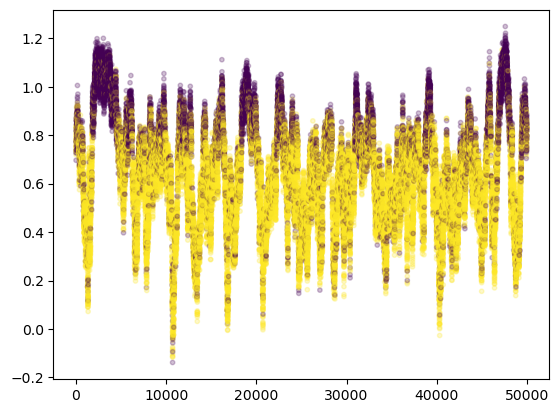

In [ ]:
error_theta = np.hstack([proposal_thetas, error])

x = error_theta[:, 0]
y = error_theta[:, 1]
z = error_theta[:, 2]

scatter = plt.scatter(np.arange(proposal_thetas.shape[0]), proposal_thetas[:,2], c=acceptance_res, s=10, alpha=0.25)
axs[i].set_xlabel(r"#iter")

Text(0.5, 4.444444444444445, '#iter')

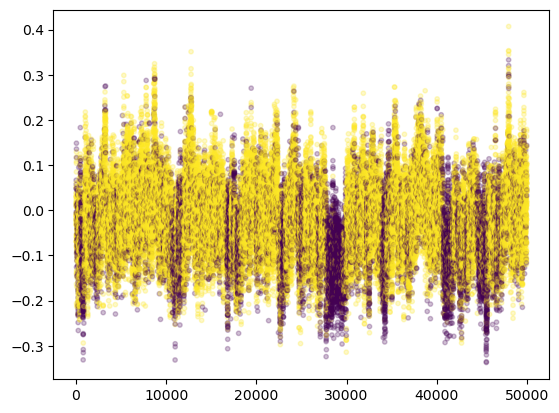

In [ ]:
error_theta = np.hstack([proposal_thetas, error])

x = error_theta[:, 0]
y = error_theta[:, 1]
z = error_theta[:, 2]

scatter = plt.scatter(np.arange(proposal_thetas.shape[0]), proposal_thetas[:,3], c=acceptance_res, s=10, alpha=0.25)
axs[i].set_xlabel(r"#iter")


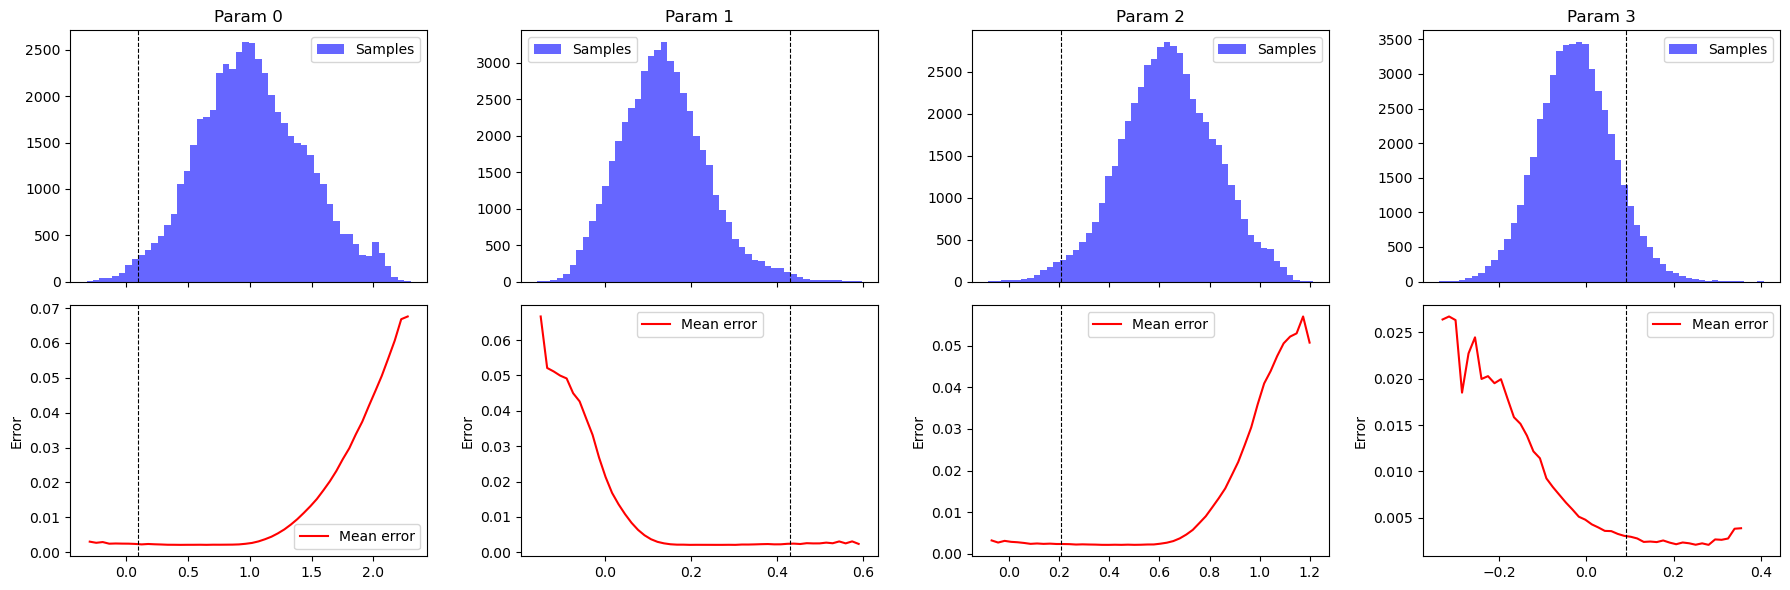

In [ ]:
from Base.utilities import histogram_,stat_ar
bins = 50
theta_th =  np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
#sample= np.load(f'./results/PIGP_spatial6_nsol10_kl2_var0.0001.npy')
sample = proposal_thetas
param_dim = sample.shape[-1]

fig, axs = plt.subplots(2, param_dim, figsize=(18, 6), sharex="col")

bins = 50

for i in range(param_dim):
    # Histogram of samples
    bin_counts, bin_edges = np.histogram(sample[:, i], bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    axs[0, i].bar(bin_centers, bin_counts, width=(bin_edges[1] - bin_edges[0]),
                  alpha=0.6, color="blue", label="Samples")
    axs[0, i].axvline(x=theta_th[i], color="black", linestyle="--", linewidth=0.8)
    axs[0, i].set_title(f"Param {i}")
    axs[0, i].legend()
    
    # Mean error per bin
    digitized = np.digitize(sample[:, i], bin_edges)
    bin_errors = [error[digitized == j].mean() if np.any(digitized == j) else np.nan
                  for j in range(1, len(bin_edges))]
    
    axs[1, i].plot(bin_centers, bin_errors, color="red", linewidth=1.5, label="Mean error")
    axs[1, i].axvline(x=theta_th[i], color="black", linestyle="--", linewidth=0.8)
    axs[1, i].set_ylabel("Error")
    axs[1, i].legend()

plt.tight_layout()
plt.show()


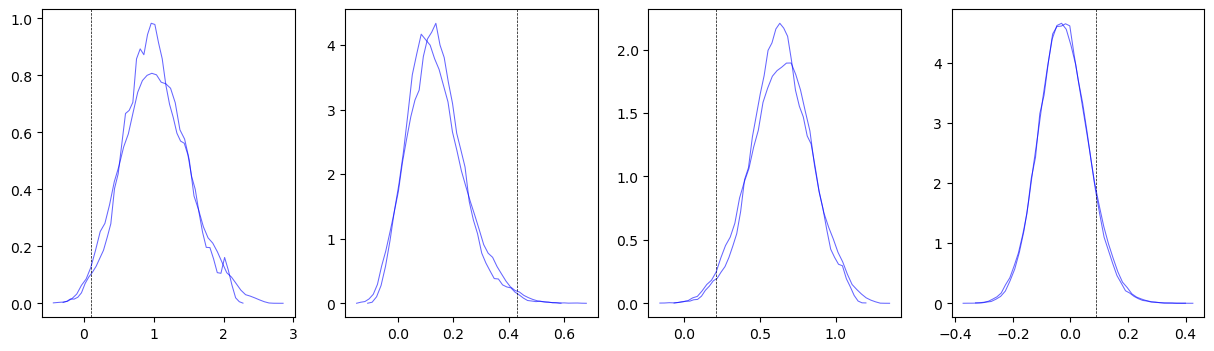

In [ ]:
from Base.utilities import histogram_,stat_ar
bins = 50
theta_th =  np.array([0.098, 0.430, 0.206, 0.090, -0.153, 0.292])
#sample= np.load(f'./results/PIGP_spatial6_nsol10_kl2_var0.0001.npy')
sample = proposal_thetas
param_dim = sample.shape[-1]
chain_fem = np.load(f'./results/FEM_kl{param_dim}_var0.0001.npy')

fig, axs = plt.subplots(1,param_dim, figsize=(15, 4))

for i in range(param_dim):
    bin_centers, counts = histogram_(sample[:, i],bins=bins)
    axs[i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75, label = r"$\pi_{\text{mean}}$",color = "blue")
    axs[i].axvline(x=theta_th[i], color='black', linestyle="--", linewidth=0.5)

    bin_centers, counts = histogram_(chain_fem[:, i],bins=bins)
    axs[i].plot(bin_centers, counts, alpha=0.6, linestyle="-", linewidth=0.75, label = r"$\pi_{\text{mean}}$",color = "blue")



